In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagGPTEstimator


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so...


/home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


[2023-07-28 16:27:27,092] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
dataset = get_dataset("electricity")

In [6]:
?LagGPTEstimator

Init signature:
LagGPTEstimator(
    prediction_length: int,
    context_length: Optional[int] = None,
    input_size: int = 1,
    n_layer: int = 1,
    n_embd: int = 32,
    n_head: int = 4,
    max_context_length: int = 2048,
    rope_scaling=None,
    scaling: Optional[str] = 'mean',
    lr: float = 0.001,
    weight_decay: float = 1e-08,
    aug_prob: float = 0.1,
    aug_rate: float = 0.1,
    distr_output: gluonts.torch.distributions.distribution_output.DistributionOutput = gluonts.torch.distributions.studentT.StudentTOutput(),
    loss: gluonts.torch.modules.loss.DistributionLoss = NegativeLogLikelihood(beta=0.0),
    num_parallel_samples: int = 100,
    batch_size: int = 32,
    num_batches_per_epoch: int = 50,
    trainer_kwargs: Optional[Dict[str, Any]] = None,
    train_sampler: Optional[gluonts.transform.sampler.InstanceSampler] = None,
    validation_sampler: Optional[gluonts.transform.sampler.InstanceSampler] = None,
    ckpt_path: Optional[str] = None,
) -> None
Docstri

In [9]:
estimator = LagGPTEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    
    scaling="std",
    rope_scaling=dict(type="linear", factor=2.0),
    # nhead=2,
    n_layer=4,
    # num_decoder_layers=2,
    # dim_feedforward=16,
    # activation="gelu",
    
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=50),
    
)

In [10]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

Authorization required, but no authorization protocol specified
Using bfloat16 Automatic Mixed Precision (AMP)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.67382 (best 5.67382), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.38786 (best 5.38786), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.33081 (best 5.33081), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.30246 (best 5.30246), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.26671 (best 5.26671), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [15]:
forecasts = list(forecast_it)

In [16]:
tss = list(ts_it)

In [17]:
evaluator = Evaluator()

In [18]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 34099.91it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

In [19]:
agg_metrics

{'MSE': 1057479.067279721,
 'abs_error': 6822713.870083876,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6399925141820528,
 'MAPE': 0.0825288186511463,
 'sMAPE': 0.09203665390579746,
 'MSIS': 6.065926374607562,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 2886644.023713705,
 'Coverage[0.1]': 0.1292834890965732,
 'QuantileLoss[0.2]': 4500814.358396497,
 'Coverage[0.2]': 0.22702492211838007,
 'QuantileLoss[0.3]': 5627216.750658615,
 'Coverage[0.3]': 0.3186656282450675,
 'QuantileLoss[0.4]': 6394854.0763068115,
 'Coverage[0.4]': 0.3993843643376354,
 'QuantileLoss[0.5]': 6822713.874451406,
 'Coverage[0.5]': 0.4778408248034416,
 'QuantileLoss[0.6]': 6957275.892076613,
 'Coverage[0.6]': 0.5507528556593978,
 'QuantileLoss[0.7]': 6713768.596442076,
 'Coverage[0.7]': 0.6302662809672156,
 'QuantileLoss[0.8]': 5981523.326142235,
 'Coverage[0.8]': 0.7158989764129952,
 'QuantileLoss[0.9]': 4582905.546175531,
 'Co

In [19]:
agg_metrics

{'MSE': 1699353.3605744469,
 'abs_error': 7915254.201302687,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.673017229115215,
 'MAPE': 0.0925330129097111,
 'sMAPE': 0.09874831644566463,
 'MSIS': 5.436230429382124,
 'QuantileLoss[0.1]': 3191534.9403455807,
 'Coverage[0.1]': 0.08442738466102952,
 'QuantileLoss[0.2]': 5158144.203989559,
 'Coverage[0.2]': 0.1815198041833556,
 'QuantileLoss[0.3]': 6537250.36521844,
 'Coverage[0.3]': 0.2831367749592048,
 'QuantileLoss[0.4]': 7449845.689399119,
 'Coverage[0.4]': 0.3864040943480196,
 'QuantileLoss[0.5]': 7915254.207095364,
 'Coverage[0.5]': 0.49195223260643817,
 'QuantileLoss[0.6]': 7986841.531431158,
 'Coverage[0.6]': 0.5835929387331257,
 'QuantileLoss[0.7]': 7462329.538075933,
 'Coverage[0.7]': 0.6905689066904019,
 'QuantileLoss[0.8]': 6362337.498570402,
 'Coverage[0.8]': 0.7890149829402165,
 'QuantileLoss[0.9]': 4403064.440043806,
 'Coverage[0.9]': 0.8873127132472927,


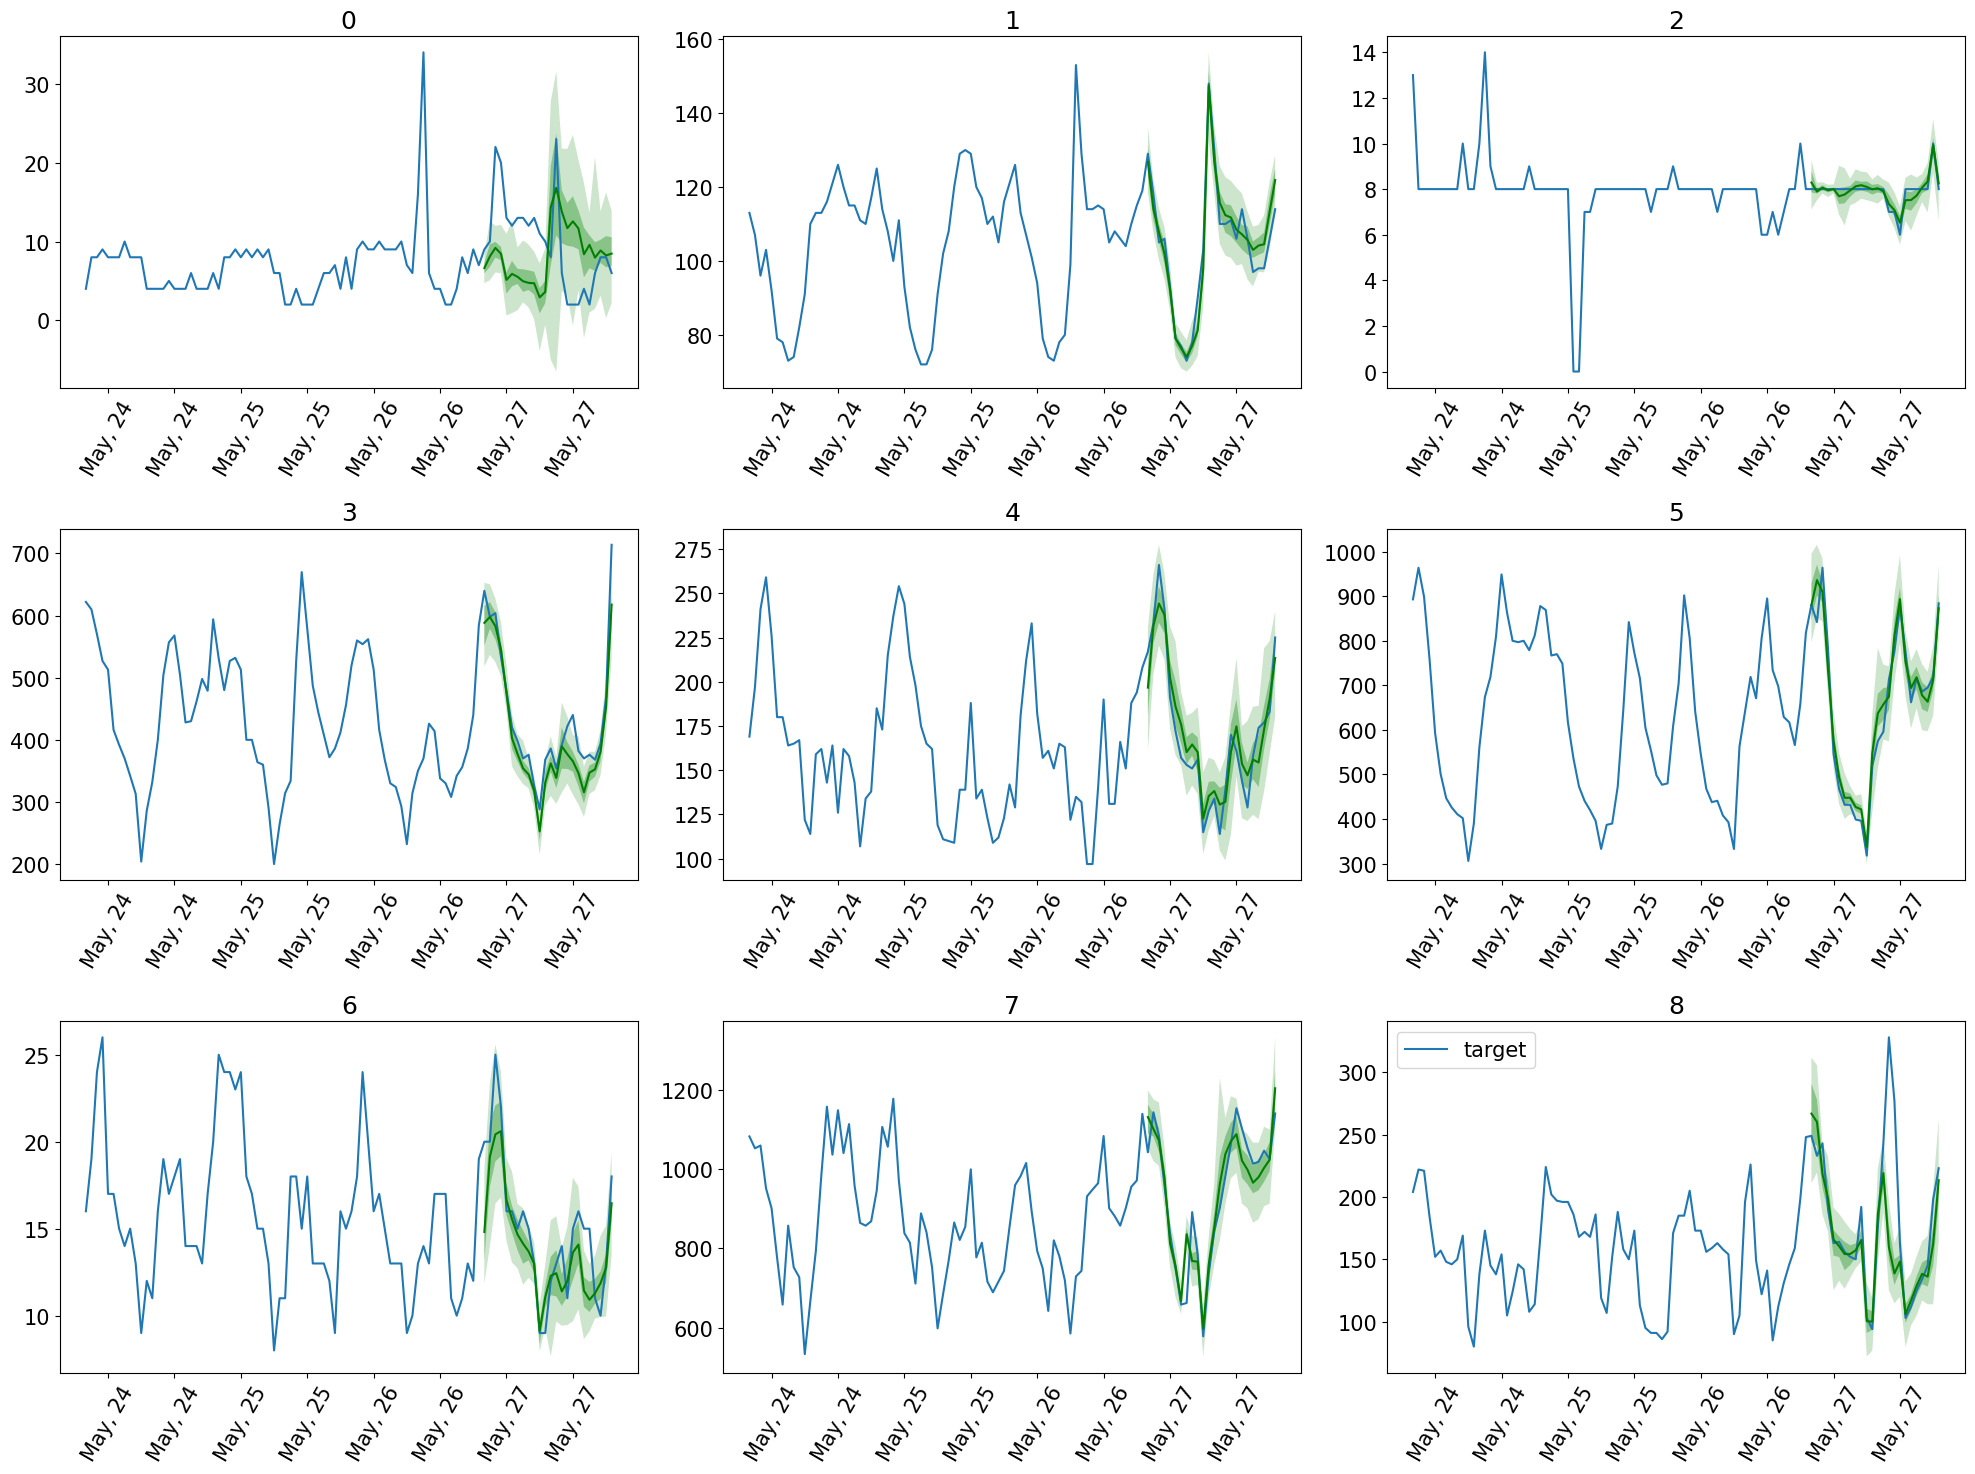

In [20]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [22]:
crpss = []
for i in range(79):
    estimator = LagGPTEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        
        scaling="std",
        rope_scaling=dict(type="linear", factor=2.0),
        n_layer=4,
        
        batch_size=256,
        num_batches_per_epoch=1,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=1),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_41/checkpoints/epoch=49-step=5000.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    crpss.append(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 117 K 
--------------------------------------
117 K     Trainable params
0         Non-trainable params
117 K     Total params
0.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.26531 (best 5.26531), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_42/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 35273.03it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.03089 (best 5.03089), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_43/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 31907.02it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 4.90849 (best 4.90849), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_44/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30660.18it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 4.84964 (best 4.84964), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_45/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 32479.81it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.05914 (best 5.05914), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_46/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 31540.45it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.07827 (best 5.07827), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_47/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 25977.11it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.05793 (best 5.05793), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_48/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30335.20it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.06026 (best 5.06026), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_49/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30466.21it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.08478 (best 5.08478), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_50/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29657.44it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.10158 (best 5.10158), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_51/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 34548.80it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 4.98838 (best 4.98838), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_52/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30307.98it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.15828 (best 5.15828), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_53/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 33385.41it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.21215 (best 5.21215), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_54/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29073.02it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.22319 (best 5.22319), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_55/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 26343.58it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.12426 (best 5.12426), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_56/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29177.88it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.18297 (best 5.18297), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_57/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29226.92it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.19354 (best 5.19354), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_58/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 34181.16it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.39094 (best 5.39094), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_59/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29921.08it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, m

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.87797 (best 5.87797), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_60/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


KeyboardInterrupt: 

Text(0, 0.5, 'CRPS')

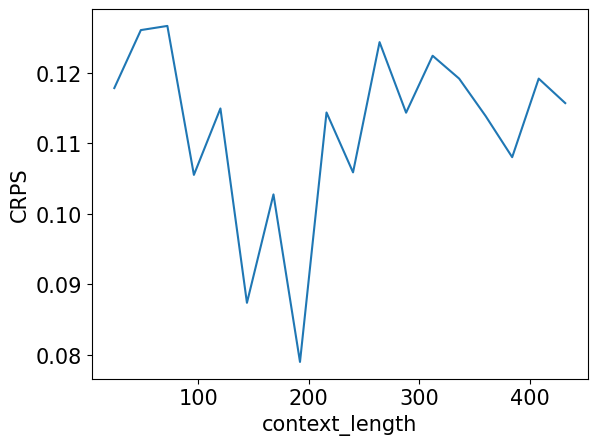

In [23]:
plt.plot([(i+1)*24 for i in range(len(crpss))], crpss)
plt.xlabel("context_length")
plt.ylabel("CRPS")